*Step 1: Import necessary packages*

In [2]:
import os

from apiclient import discovery
from httplib2 import Http
import oauth2client
from oauth2client import file, client, tools
import pandas as pd
import nrrd
import nibabel as nib
import io
from googleapiclient.http import MediaIoBaseDownload
import cv2
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt

#Importing files from my packages
import register
import gdaccess
import preprocess

ModuleNotFoundError: No module named 'oauth2client'

*Step 2: Importing the photo used for practice*

In [2]:
im = imread('/Volumes/imagereg/6-26-19-tiffexport/test3.tif')

*Step 3: Getting the image and prepping it to be registered**

In [3]:
im_max = np.max(im, axis = 0)

In [4]:
blue = im_max[:,:,2]

In [5]:
blue.shape

(5390, 3609)

*Step 4: Getting the registration points for the moving image*

In [34]:
binary = register.mim_edge_detector(blue)

In [35]:
binary = register.image_cleaning(binary)

In [8]:
coor_df = register.find_points(binary)

*Step 5: Visualizing the image registration points*

In [9]:
binaryx, binaryy = binary.shape
checkpoints = np.zeros([binaryx, binaryy, 3], dtype=np.uint8)

In [10]:
for row in coor_df.itertuples():
    x = row.M_x
    y = row.M_y
    register.red_points(x,y,binary, checkpoints)

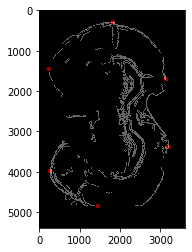

In [11]:
plt.imshow(binary, cmap='gray')
plt.imshow(checkpoints, alpha=0.6);

*Step 6: Getting the appropriate atlas slice for the image*

In [12]:
df = pd.read_excel('distances.xlsx')
df.head()

,Slidetag,Atlas Slice
0,slide1_slice1,51
1,slide2_slice1,52
2,slide3_slice1,53
3,slide4_slice1,53
4,slide5_slice1,54


*Step 7: Getting the registration points for the atlas slice*

In [13]:
file = '/Users/HawleyHelm/Desktop/image-registration/Dawley-p14/NITRC-dti_rat_atlas-Downloads/atlas_segmentation.nrrd'

In [14]:
F_im_nii = register.nrrd_to_nii(file)

In [15]:
slice_number = df['Atlas Slice'][0]

In [1]:
sagittal, coronal, horizontal = register.atlas_slice(F_im_nii, slice_number)

NameError: name 'register' is not defined

In [17]:
resized = preprocess.resize(coronal, 20)

In [18]:
resized = register.mim_edge_detector(resized)

In [19]:
fim_coor_df = register.find_points(resized)

In [20]:
binaryx, binaryy = resized.shape
checkpoints = np.zeros([binaryx, binaryy, 3], dtype=np.uint8)

In [21]:
for row in fim_coor_df.itertuples():
    x = row.M_x
    y = row.M_y
    register.red_points(x,y,resized, checkpoints)

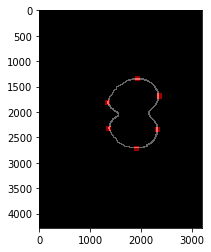

In [22]:
plt.imshow(resized, cmap='gray')
plt.imshow(checkpoints, alpha=0.6);

*Step 8: Registration*

In [23]:
#Change the fim_coor_df to have the proper labels
df = pd.concat([coor_df, fim_coor_df], axis = 1)

In [24]:
ainv = register.reg_coefficients(df)

In [25]:
registered_im = register.registration(blue, ainv)

*Step 9: Saving registered image to a .nii file*

In [26]:
Registered_stack = np.zeros(resized.shape)

In [27]:
Registered_stack = np.vstack([Registered_stack[np.newaxis,:,:] , registered_im[np.newaxis,:,:]])

In [28]:
Registered_stack.shape

(2, 4280, 3200)

*Step 10: Saving the file to my computer*

In [29]:
M_im_nii = nib.Nifti2Image(Registered_stack, affine=np.eye(4))

In [30]:
M_im_nii.get_data_dtype() == np.dtype(np.int16)

False

In [31]:
M_im_nii.header.get_xyzt_units()

('unknown', 'unknown')

In [32]:
nib.save(M_im_nii, os.path.join('/Users/HawleyHelm/Desktop/image-registration/Dawley-p14','fullbraintest.nii.gz'))